### SARIMA 1 ตัวแปร
#### จำนวนผู้ป่วย

In [1]:
import warnings; 
warnings.filterwarnings("ignore")
warnings.simplefilter(action="ignore",category=UserWarning)
warnings.simplefilter(action="ignore",category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import math
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox

from sklearn.metrics import mean_squared_error

import itertools

import statsmodels.api as sm
from pylab import rcParams
from PyAstronomy import pyasl

#### Import Data

In [2]:
all_df = pd.read_csv('data/case_all.csv',parse_dates=True)
all_df.info()
all_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232 entries, 0 to 231
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        232 non-null    object 
 1   total_case  232 non-null    int64  
 2   temp        232 non-null    float64
 3   press       224 non-null    float64
 4   humidity    232 non-null    float64
 5   rain        232 non-null    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 11.0+ KB


,date,total_case,temp,press,humidity,rain
0,2019-01-07,30,27.282259,1005.820689,85.897126,7.777041
1,2019-01-14,18,27.177412,1005.009584,81.642037,4.164286
2,2019-01-21,18,26.849482,1007.035567,79.545775,0.621429
3,2019-01-28,23,27.270083,1006.782040,83.890311,5.496281
4,2019-02-04,28,27.903425,1008.452154,78.378565,0.078027
...,...,...,...,...,...,...
227,2023-12-01,28,26.863721,1007.435911,89.920629,5.500238
228,2023-12-08,24,26.813490,1007.187055,89.482885,32.002381
229,2023-12-15,18,27.116654,1008.151154,88.796577,6.510595
230,2023-12-22,11,25.604502,1010.282544,94.228968,59.655238


In [3]:
# แปลงคอลัมน์ date ให้เป็นวันที่
all_df['date'] = pd.to_datetime(all_df['date'], format='%Y-%m-%d')

In [4]:
# ตั้งค่า start_date เป็น index
all_df.set_index('date', inplace=True)
all_df

,total_case,temp,press,humidity,rain
date,,,,,
2019-01-07,30,27.282259,1005.820689,85.897126,7.777041
2019-01-14,18,27.177412,1005.009584,81.642037,4.164286
2019-01-21,18,26.849482,1007.035567,79.545775,0.621429
2019-01-28,23,27.270083,1006.782040,83.890311,5.496281
2019-02-04,28,27.903425,1008.452154,78.378565,0.078027
...,...,...,...,...,...
2023-12-01,28,26.863721,1007.435911,89.920629,5.500238
2023-12-08,24,26.813490,1007.187055,89.482885,32.002381
2023-12-15,18,27.116654,1008.151154,88.796577,6.510595


In [5]:
total_case_df = all_df['total_case']
total_case_df

date
2019-01-07    30
2019-01-14    18
2019-01-21    18
2019-01-28    23
2019-02-04    28
              ..
2023-12-01    28
2023-12-08    24
2023-12-15    18
2023-12-22    11
2023-12-29    22
Name: total_case, Length: 232, dtype: int64

Plot time series

count    232.000000
mean      22.500000
std       20.103843
min        1.000000
25%        4.000000
50%       19.000000
75%       32.000000
max      104.000000
Name: total_case, dtype: float64


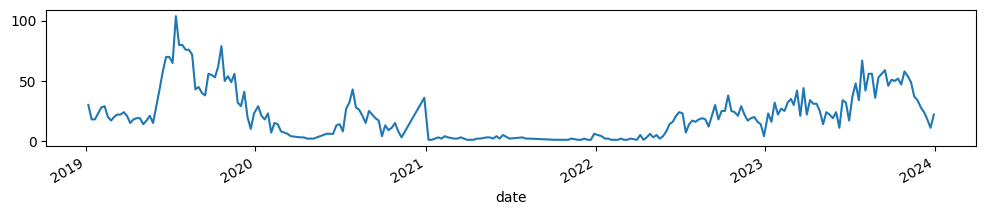

In [6]:
# Show some descriptive statistics and do timeseries plot
print(total_case_df.describe())
total_case_df.plot(figsize=(12,2));

ตรวจสอบค่าว่าง

In [7]:
y_nan = total_case_df
print(y_nan.head())
print('Series has {} missing values'.format(y_nan.isna().sum()))
date_missed = y_nan[y_nan.isna()].index #เก็บindex ที่หายไปว่ามีอันไหนบ้าง

date
2019-01-07    30
2019-01-14    18
2019-01-21    18
2019-01-28    23
2019-02-04    28
Name: total_case, dtype: int64
Series has 0 missing values


In [8]:
total_case_df.isnull().sum()

0

Interpolate the missing values

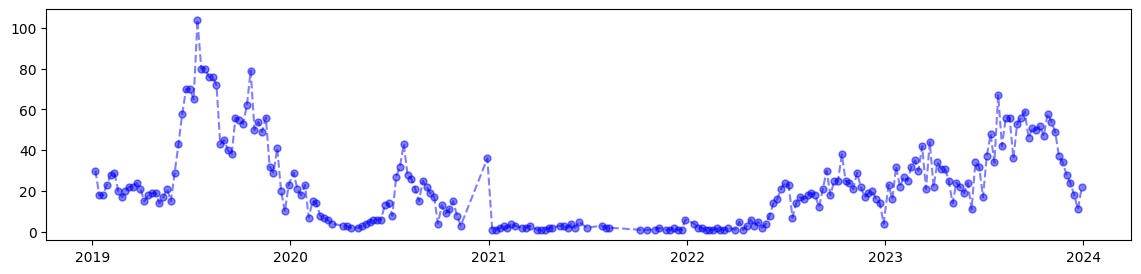

In [9]:
total_case_filled = y_nan.interpolate(method='linear')

plt.figure(figsize=(14,3))
plt.plot(y_nan, 'bo--', alpha=0.5, ms=5)
plt.plot(total_case_filled.loc[date_missed],'ro', ms=5)
plt.show()

<Axes: xlabel='date'>

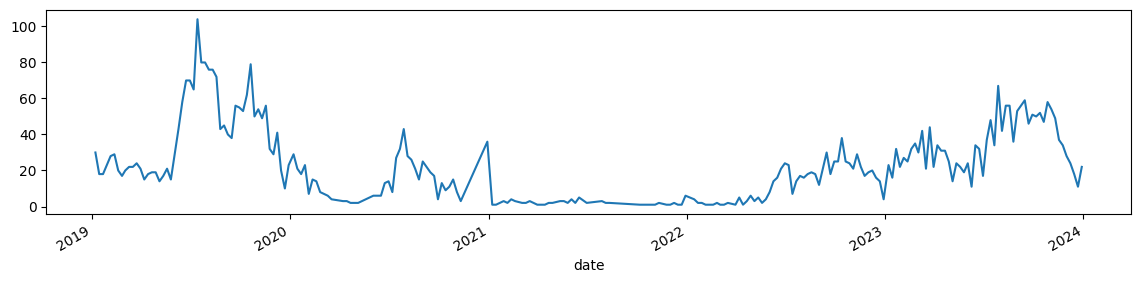

In [10]:
total_case_filled.plot(figsize=(14,3))

In [11]:
print(total_case_filled.head())
print('Series has {} missing values'.format(total_case_filled.isna().sum()))
date_missed = total_case_filled[total_case_filled.isna()].index

date
2019-01-07    30
2019-01-14    18
2019-01-21    18
2019-01-28    23
2019-02-04    28
Name: total_case, dtype: int64
Series has 0 missing values


In [ ]:
#plt.rcParams['figure.figsize'] = (10,6)
#decomp = sm.tsa.seasonal_decompose(total_case_filled, model='additive')
#decomp.plot();

Data Transformation
- Variance Stabilization

<Axes: xlabel='date'>

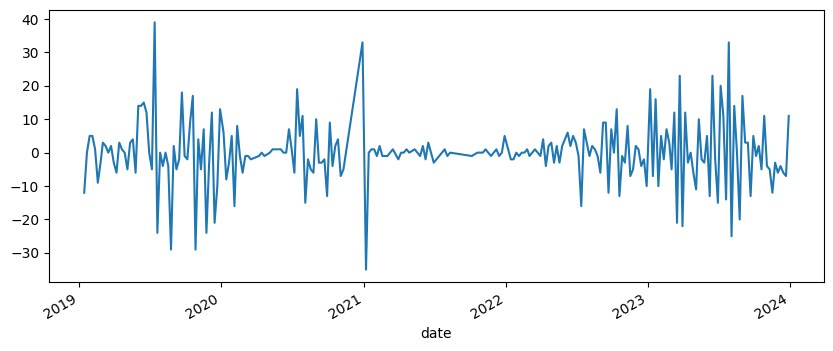

In [12]:
# Detrending
detrend_ts = (total_case_filled).diff()
detrend_ts.plot(figsize=(10,4))

<Axes: xlabel='date'>

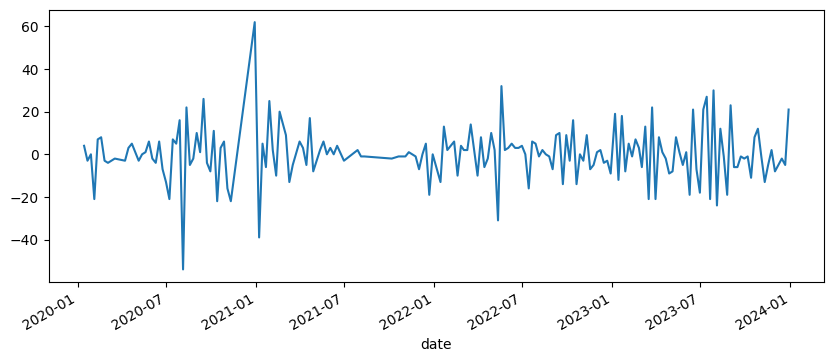

In [13]:
# Deseasonalizing
deseason_ts = (total_case_filled).diff().diff(52)
deseason_ts.plot(figsize=(10,4))

In [14]:
from statsmodels.stats.diagnostic import acorr_ljungbox

h = min(10, len((total_case_df).diff().diff(52).dropna())/5)
lb_result = acorr_ljungbox((total_case_filled).diff().diff(52).dropna(), lags=h)
lb_result

,lb_stat,lb_pvalue
1,41.304532,1.302665e-10
2,41.782912,8.451932e-10
3,41.867891,4.279648e-09
4,42.044543,1.633073e-08
5,42.065134,5.714317e-08
6,43.372332,9.843578e-08
7,43.405022,2.785655e-07
8,44.777623,4.054886e-07
9,45.194234,8.493851e-07
10,45.478224,1.782560e-06


##### ตรวจสอบ Outlier

In [53]:
#total_case_outlier_ts_transformed = np.log(total_case_filled).diff().diff(4).dropna()

In [54]:
#n = len(total_case_outlier_ts_transformed)

#max_outliers, alpha = 2, 0.05
#num_outlier, indices = pyasl.generalizedESD(total_case_outlier_ts_transformed, max_outliers, alpha)

#print("Number of outliers: ", num_outlier)
#print("Indices of outliers: ", indices)
## print("        R      Lambda")
## for i in range(len(r[2])):
##   print("%2d  %8.5f  %8.5f" % ((i+1), r[2][i], r[3][i]))

## Plot the "data"
#lt.figure(figsize=(10,4))
#plt.plot(y_outlier_ts_transformed, 'b.', ms=10, alpha=0.5, linestyle='--')
#plt.plot(y_outlier_ts_transformed[indices], 'rp', ms=10, alpha=0.5)

Number of outliers:  2
Indices of outliers:  [90, 94]


<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

In [ ]:
# Drop outlier
#total_case_outlier_ts = total_case_outlier_ts_transformed.drop(total_case_outlier_ts_transformed[99,103].index)

##### ADF test

In [15]:
# ADF test
print('Results of Augmented Dickey-Fuller Test:')
dftest = adfuller(total_case_df)
dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
print(dfoutput)

Results of Augmented Dickey-Fuller Test:
Test Statistic   -2.956608
p-value           0.039150
dtype: float64


ACF PACF

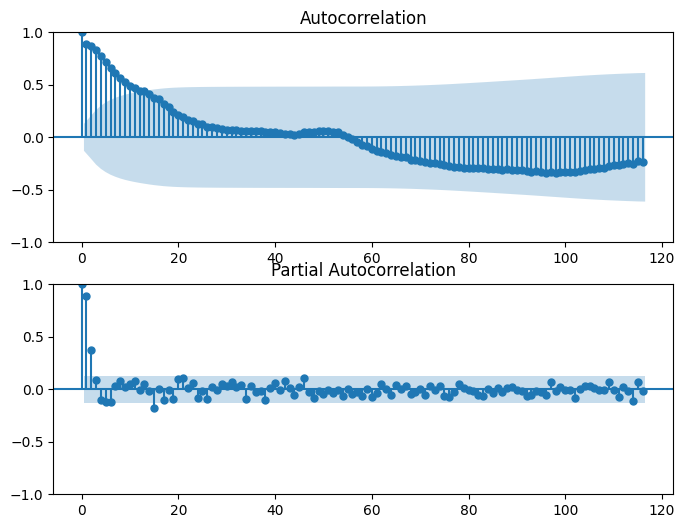

In [16]:
max_lag = max(10, len(total_case_df)/2)
fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 6))
plot_acf(total_case_filled, lags=max_lag, ax=ax1); 
plot_pacf(total_case_filled, lags=max_lag, ax=ax2);

#### Split the data set

In [17]:
split_ratio = 0.7 #train70%Z(1-70%) test30%(71-100%)
train_size = int(len(total_case_df)*split_ratio)
Y_train, Y_test = total_case_df[:train_size], total_case_df[train_size:]

In [18]:
#Grid search SARIMA
import itertools

def grid_search_SARIMA(Y_train, max_p, max_d, max_q, max_P, max_D, max_Q, s):

    results = []

    pdq = np.arange(max_p+1), np.arange(max_d+1), np.arange(max_q+1)
    PDQs = np.arange(max_P+1), np.arange(max_D+1), np.arange(max_Q+1), [s]

    for p, d, q in itertools.product(*pdq): #product(*pdq)หาทุกค่าของ pdqทั้งหมด
        for P, D, Q, s in itertools.product(*PDQs):
            order = (p, d, q)
            seasonal_order = (P, D, Q, s)
            model = SARIMAX(Y_train, order=order, seasonal_order=seasonal_order)
            model_fit = model.fit(disp=False)
            yhat = model_fit.predict()
            error = model_fit.aicc #.aicc ค่าที่วัดผล เออเร่อเท่าไร
            results.append((order, seasonal_order, error))
            print(f'SARIMAX{order}x{seasonal_order} - AICC:{error}')

    return results

In [19]:
results = grid_search_SARIMA(Y_train, max_p=1,max_d=1,max_q=1,max_P=1,max_D=1,max_Q=1,s=52)

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMAX(0, 0, 0)x(0, 0, 0, 52) - AICC:1542.9288809997606
SARIMAX(0, 0, 0)x(0, 0, 1, 52) - AICC:1520.9034317985738


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMAX(0, 0, 0)x(0, 1, 0, 52) - AICC:1031.7557142605726


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMAX(0, 0, 0)x(0, 1, 1, 52) - AICC:1028.9420521415136


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMAX(0, 0, 0)x(1, 0, 0, 52) - AICC:1516.235571830342


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMAX(0, 0, 0)x(1, 0, 1, 52) - AICC:1517.1930767130816


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMAX(0, 0, 0)x(1, 1, 0, 52) - AICC:1028.9516367133203


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMAX(0, 0, 0)x(1, 1, 1, 52) - AICC:1031.007048077752
SARIMAX(0, 0, 1)x(0, 0, 0, 52) - AICC:1395.7293119319925


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMAX(0, 0, 1)x(0, 0, 1, 52) - AICC:1390.1292332700953
SARIMAX(0, 0, 1)x(0, 1, 0, 52) - AICC:964.3020529225001


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMAX(0, 0, 1)x(0, 1, 1, 52) - AICC:966.3918429524551


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMAX(0, 0, 1)x(1, 0, 0, 52) - AICC:1388.4641415506082


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMAX(0, 0, 1)x(1, 0, 1, 52) - AICC:1390.4447871545242


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMAX(0, 0, 1)x(1, 1, 0, 52) - AICC:966.3923613209857


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX(0, 0, 1)x(1, 1, 1, 52) - AICC:968.5182252963667
SARIMAX(0, 1, 0)x(0, 0, 0, 52) - AICC:1153.7587074430328


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMAX(0, 1, 0)x(0, 0, 1, 52) - AICC:1153.1467775365904


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMAX(0, 1, 0)x(0, 1, 0, 52) - AICC:871.6082991802458


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMAX(0, 1, 0)x(0, 1, 1, 52) - AICC:854.7851249933067


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMAX(0, 1, 0)x(1, 0, 0, 52) - AICC:1153.4153109109914


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMAX(0, 1, 0)x(1, 0, 1, 52) - AICC:1154.7721064458601


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMAX(0, 1, 0)x(1, 1, 0, 52) - AICC:855.2616131559956


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMAX(0, 1, 0)x(1, 1, 1, 52) - AICC:856.7616783384852
SARIMAX(0, 1, 1)x(0, 0, 0, 52) - AICC:1142.460642682792


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMAX(0, 1, 1)x(0, 0, 1, 52) - AICC:1144.2161980082083
SARIMAX(0, 1, 1)x(0, 1, 0, 52) - AICC:844.8197561626679


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMAX(0, 1, 1)x(0, 1, 1, 52) - AICC:839.2165278054671


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMAX(0, 1, 1)x(1, 0, 0, 52) - AICC:1144.2522968798717


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-pa

SARIMAX(0, 1, 1)x(1, 0, 1, 52) - AICC:1145.9018079341963
SARIMAX(0, 1, 1)x(1, 1, 0, 52) - AICC:839.5008015123695


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX(0, 1, 1)x(1, 1, 1, 52) - AICC:841.1712791611784
SARIMAX(1, 0, 0)x(0, 0, 0, 52) - AICC:1161.2435944323706


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMAX(1, 0, 0)x(0, 0, 1, 52) - AICC:1161.238570745855
SARIMAX(1, 0, 0)x(0, 1, 0, 52) - AICC:875.2137714115488


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMAX(1, 0, 0)x(0, 1, 1, 52) - AICC:860.8717988118561


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMAX(1, 0, 0)x(1, 0, 0, 52) - AICC:1161.4237724102093


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMAX(1, 0, 0)x(1, 0, 1, 52) - AICC:1163.0866578767861


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMAX(1, 0, 0)x(1, 1, 0, 52) - AICC:861.6448250808068


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMAX(1, 0, 0)x(1, 1, 1, 52) - AICC:863.0063801832245
SARIMAX(1, 0, 1)x(0, 0, 0, 52) - AICC:1151.8136235053614


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMAX(1, 0, 1)x(0, 0, 1, 52) - AICC:1153.640215288883


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMAX(1, 0, 1)x(0, 1, 0, 52) - AICC:853.9670833090439


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMAX(1, 0, 1)x(0, 1, 1, 52) - AICC:848.0280812707134


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMAX(1, 0, 1)x(1, 0, 0, 52) - AICC:1153.6688436634333


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMAX(1, 0, 1)x(1, 0, 1, 52) - AICC:1155.510480405697


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMAX(1, 0, 1)x(1, 1, 0, 52) - AICC:848.4973611933165


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMAX(1, 0, 1)x(1, 1, 1, 52) - AICC:849.9086801361982
SARIMAX(1, 1, 0)x(0, 0, 0, 52) - AICC:1143.4007499493334


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMAX(1, 1, 0)x(0, 0, 1, 52) - AICC:1145.000188805584


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMAX(1, 1, 0)x(0, 1, 0, 52) - AICC:850.6482063759713


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMAX(1, 1, 0)x(0, 1, 1, 52) - AICC:841.7769373036848


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMAX(1, 1, 0)x(1, 0, 0, 52) - AICC:1145.0530338918752


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX(1, 1, 0)x(1, 0, 1, 52) - AICC:1146.6542415346785


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMAX(1, 1, 0)x(1, 1, 0, 52) - AICC:842.129242898465


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX(1, 1, 0)x(1, 1, 1, 52) - AICC:843.7988200944122
SARIMAX(1, 1, 1)x(0, 0, 0, 52) - AICC:1144.3269587112413


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMAX(1, 1, 1)x(0, 0, 1, 52) - AICC:1146.1392442155345


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMAX(1, 1, 1)x(0, 1, 0, 52) - AICC:846.4398658336701


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMAX(1, 1, 1)x(0, 1, 1, 52) - AICC:840.995843913495


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMAX(1, 1, 1)x(1, 0, 0, 52) - AICC:1146.172215856622


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-pa

SARIMAX(1, 1, 1)x(1, 0, 1, 52) - AICC:1147.8569471353321
SARIMAX(1, 1, 1)x(1, 1, 0, 52) - AICC:841.2671521328617


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX(1, 1, 1)x(1, 1, 1, 52) - AICC:842.993459091947


In [20]:
# Print top 10 best models
print("\nTop 10 best SARIMAX configurations:")
for i, (order, seasonal_order, error) in enumerate(sorted(results, key=lambda x: x[2])[:10]):
    print(f'{i+1}: SARIMAX{order}x{seasonal_order} - AICC:{error}')


Top 10 best SARIMAX configurations:
1: SARIMAX(0, 1, 1)x(0, 1, 1, 52) - AICC:839.2165278054671
2: SARIMAX(0, 1, 1)x(1, 1, 0, 52) - AICC:839.5008015123695
3: SARIMAX(1, 1, 1)x(0, 1, 1, 52) - AICC:840.995843913495
4: SARIMAX(0, 1, 1)x(1, 1, 1, 52) - AICC:841.1712791611784
5: SARIMAX(1, 1, 1)x(1, 1, 0, 52) - AICC:841.2671521328617
6: SARIMAX(1, 1, 0)x(0, 1, 1, 52) - AICC:841.7769373036848
7: SARIMAX(1, 1, 0)x(1, 1, 0, 52) - AICC:842.129242898465
8: SARIMAX(1, 1, 1)x(1, 1, 1, 52) - AICC:842.993459091947
9: SARIMAX(1, 1, 0)x(1, 1, 1, 52) - AICC:843.7988200944122
10: SARIMAX(0, 1, 1)x(0, 1, 0, 52) - AICC:844.8197561626679


#### Fit best model

In [21]:
import math
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

def get_forecast_accuracy(y, y_hat):
    # ME
    me = (y - y_hat).sum()/len(y)

    # RMSE
    rmse = math.sqrt(mean_squared_error(y, y_hat))

    # MAPE
    mape = mean_absolute_percentage_error(y, y_hat) * 100
    
    # WAPE
    wape = (y - y_hat).__abs__().sum() / y.__abs__().sum() * 100

    print("ME: %.2f, RMSE: %.2f, MAPE: %.2f%%, WAPE: %.2f%%" % (me,rmse,mape,wape))

In [22]:
best_pdq, best_PDQS = (0, 1, 1),(0, 1, 1, 52)

sarima_fit = SARIMAX(Y_train, order=best_pdq, seasonal_order=best_PDQS).fit(disp=False) 
print(sarima_fit.summary())

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                         total_case   No. Observations:                  162
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 52)   Log Likelihood                -416.494
Date:                            Wed, 07 Aug 2024   AIC                            838.988
Time:                                    04:33:28   BIC                            847.062
Sample:                                         0   HQIC                           842.262
                                            - 162                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4127      0.076     -5.409      0.000      -0.562      -0.263
ma.S.L52      -0.5122      0.211   

In [71]:
#best_pdq, best_PDQS = (2,1,0),(0,0,0,52)

#sarima_fit = SARIMAX(Y_train, order=best_pdq, seasonal_order=best_PDQS).fit(disp=False) 
#print(sarima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             total_case   No. Observations:                  162
Model:               SARIMAX(2, 1, 0)   Log Likelihood                -568.540
Date:                Tue, 06 Aug 2024   AIC                           1143.079
Time:                        01:01:49   BIC                           1152.324
Sample:                             0   HQIC                          1146.833
                                - 162                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3056      0.051     -5.960      0.000      -0.406      -0.205
ar.L2         -0.1177      0.079     -1.486      0.137      -0.273       0.038
sigma2        68.3118      4.276     15.974      0.0

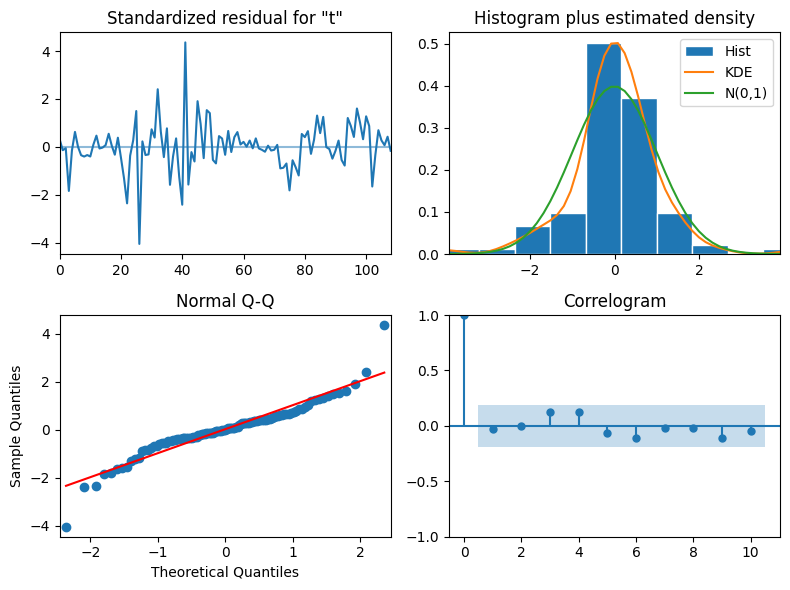

In [23]:
#Residuals diagnostic
sarima_fit.plot_diagnostics(figsize=(8, 6))
plt.tight_layout();

#### Fitted values¶

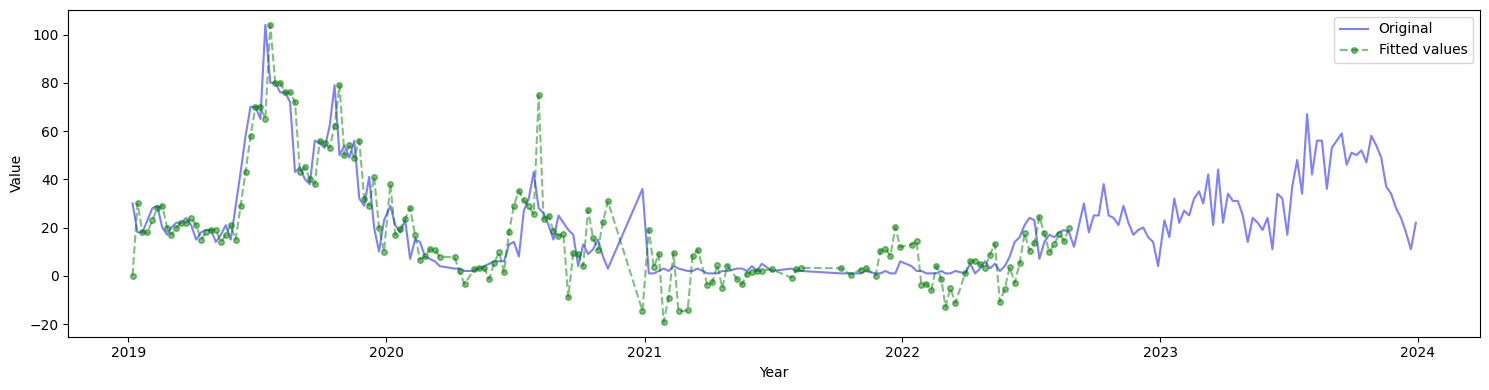

In [60]:
plt.figure(figsize=(15,4))
plt.plot(total_case_df, alpha=0.5, color='blue', label='Original')
plt.plot(sarima_fit.fittedvalues, '--o', color='green', ms=4, label='Fitted values', alpha=0.5)
plt.legend(loc='best')
plt.xlabel('Year')
plt.ylabel('Value')
plt.tight_layout();

#### Rolling-forward CV for h-step ahead forecast

In [61]:
history = [y for y in Y_train]
train = history
predictions = list()
upper_ci = list()
lower_ci = list()


h = 4
for t in range(len(Y_test)-(h-1)):
      
  model_fit = SARIMAX(train, order=best_pdq, trend='n').fit(disp=False)
    
  output = model_fit.get_forecast(h)
  predictions.append(output.predicted_mean[h-1])
  lower_ci.append(output.conf_int()[h-1,0])
  upper_ci.append(output.conf_int()[h-1,1])

  history.append(Y_test.iloc[t])
  train = history[t+1:]

ME: 0.12, RMSE: 12.90, MAPE: 42.46%, WAPE: 31.47%


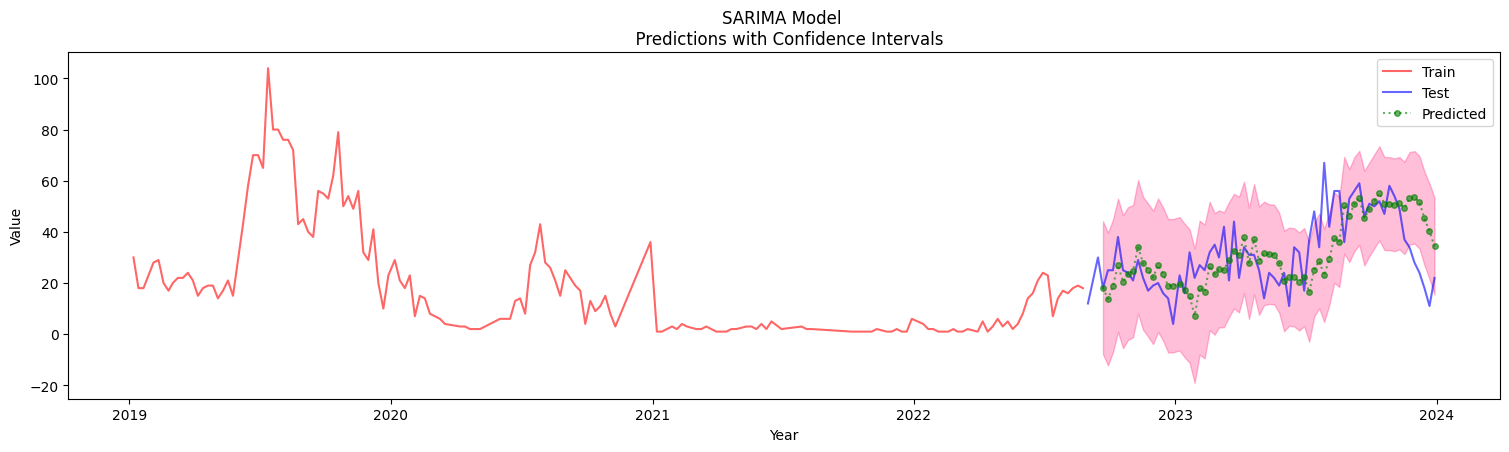

In [62]:
plt.figure(figsize=(15,4))
plt.plot(Y_train, label='Train', color='red', alpha=0.6); 
plt.plot(Y_test, label='Test', color='blue', alpha=0.6); 

predictions = pd.Series(predictions, index=Y_test.index[h-1:])
plt.plot(predictions, 'go:', label='Predicted', alpha=0.6, ms=4) 
plt.fill_between(Y_test.index[h-1:], upper_ci, lower_ci, color='#ff0066', alpha=.25)
plt.legend(loc='best')
plt.tight_layout();
plt.xlabel('Year')
plt.ylabel('Value')
plt.title("SARIMA Model \n  Predictions with Confidence Intervals")

get_forecast_accuracy(Y_test[h-1:], predictions)

In [63]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  162
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -555.097
Date:                Tue, 06 Aug 2024   AIC                           1114.194
Time:                        04:45:09   BIC                           1120.357
Sample:                             0   HQIC                          1116.696
                                - 162                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5433      0.050    -10.918      0.000      -0.641      -0.446
sigma2        57.7177      4.245     13.596      0.000      49.397      66.038
Ljung-Box (L1) (Q):                   1.82   Jarque-

#### Out of sample forecast

In [81]:
Y = total_case_df

In [ ]:
#(0,1,1),(0,1,1,52)

In [82]:
# Define the SARIMA model
sarima_model = SARIMAX(total_case_df, 
                       order=(0, 1, 1),         # (p, d, q) for the non-seasonal part
                       seasonal_order=(0, 1, 1, 52))  # (P, D, Q, m) for the seasonal part

# Fit the model
sarima_result = sarima_model.fit(disp=False)

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [90]:
sarima_result.get_forecast(steps=4)

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [96]:
# Forecast the next 12 periods (e.g., months)
forecast = sarima_result.get_forecast(steps=4)
forecast_index = pd.date_range(start=total_case_df.index[-1], periods=4, freq='W')

# Get the forecasted mean
forecast_mean = forecast.predicted_mean
forecast_mean.index = forecast_index

# Optionally, get confidence intervals
conf_int = forecast.conf_int()
conf_int.index = forecast_index

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


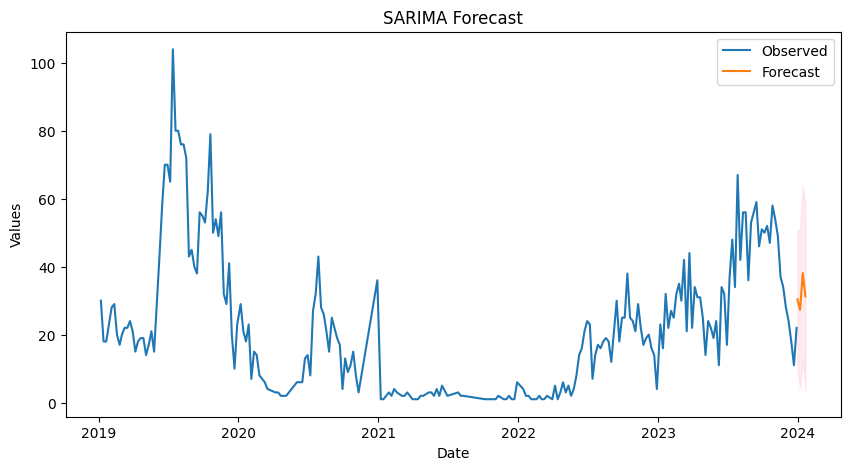

In [97]:
# Plot the actual data and forecast
plt.figure(figsize=(10, 5))
plt.plot(total_case_df, label='Observed')
plt.plot(forecast_mean, label='Forecast')
plt.fill_between(forecast_mean.index, 
                 conf_int.iloc[:, 0], 
                 conf_int.iloc[:, 1], 
                 color='pink', alpha=0.3)
plt.title('SARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.show()

In [94]:
total_case_df.tail()

date
2023-12-01    28
2023-12-08    24
2023-12-15    18
2023-12-22    11
2023-12-29    22
Name: total_case, dtype: int64

In [98]:
forecast_mean

2023-12-31    30.408407
2024-01-07    27.293930
2024-01-14    38.128884
2024-01-21    31.218669
Freq: W-SUN, Name: predicted_mean, dtype: float64

In [62]:
# Define the parameters
best_pdq, best_PDQS = (0, 1, 1)x(0, 1, 1, 52
history_Y = [y for y in Y]
predictions = list()
upper_ci = list()
lower_ci = list()

h = 4  # Number of steps to forecast

# Rolling Forecast in-sample
for t in range(len(total_case_df) - h + 1):
    model_fit = SARIMAX(history_Y, order=best_pdq, seasonal_order=best_PDQS, trend='c').fit(disp=False)
    output = model_fit.get_forecast(steps=1)
    
    conf_int = output.conf_int()
    output_df = pd.DataFrame({
        'predicted_mean': output.predicted_mean,
        'lower_ci': conf_int[:, 0],
        'upper_ci': conf_int[:, 1]
    })
    
    adjusted_lower_ci = max(0, output_df['lower_ci'].iloc[-1])
    predictions.append(output_df['predicted_mean'].iloc[-1])
    lower_ci.append(adjusted_lower_ci)
    upper_ci.append(output_df['upper_ci'].iloc[-1])
    
    # Use the forecasted value as the next point in the dataset
    history_Y.append(total_case_df.iloc[t])
    history_Y = history_Y[1:]

# Convert predictions, lower_ci, upper_ci to pandas Series
rolling_predictions_series = pd.Series(predictions, index=Y.index[h-1:len(predictions)+h-1])
lower_ci_series = pd.Series(lower_ci, index=Y.index[h-1:len(lower_ci)+h-1])
upper_ci_series = pd.Series(upper_ci, index=Y.index[h-1:len(upper_ci)+h-1])

# Rolling Forecast out-of-sample for the next 7 days
for i in range(h):
    model_fit = SARIMAX(history_Y, order=best_pdq, seasonal_order=best_PDQS, trend='n').fit(disp=False)
    output = model_fit.get_forecast(steps=1)
    
    conf_int = output.conf_int()
    output_df = pd.DataFrame({
        'predicted_mean': output.predicted_mean,
        'lower_ci': conf_int[:, 0],
        'upper_ci': conf_int[:, 1]
    })
    
    adjusted_lower_ci = max(0, output_df['lower_ci'].iloc[-1])
    predictions.append(output_df['predicted_mean'].iloc[-1])
    lower_ci.append(adjusted_lower_ci)
    upper_ci.append(output_df['upper_ci'].iloc[-1])
    
    # Use the forecasted value as the next point in the dataset
    history_Y.append(output_df['predicted_mean'].iloc[-1])

# Create Series for out-of-sample forecast
out_of_sample_index = pd.date_range(start=Y.index[-1] + pd.Timedelta(days=1), periods=h)
rolling_predictions_out_of_sample = pd.Series(predictions[-h:], index=out_of_sample_index)
lower_ci_out_of_sample = pd.Series(lower_ci[-h:], index=out_of_sample_index)
upper_ci_out_of_sample = pd.Series(upper_ci[-h:], index=out_of_sample_index)

SyntaxError: '(' was never closed (3374081007.py, line 2)

In [86]:
Y

date
2019-01-07    30
2019-01-14    18
2019-01-21    18
2019-01-28    23
2019-02-04    28
              ..
2023-12-01    28
2023-12-08    24
2023-12-15    18
2023-12-22    11
2023-12-29    22
Name: total_case, Length: 232, dtype: int64

In [54]:
#ทำ rolling สำหรับ forcast
#สร้างตัวแปร history มาเก็บค่าในการพยากรณ์ เพื่อนำกลับมาเข้า model ใหม่ แล้วพยากรณ์ค่าถัดไป
import numpy as np
best_pdq, best_PDQS = (1, 1, 1), (0, 1, 1, 7)
history_Y = [y for y in Y]
history_X = [x for x in X]
predictions = list()
upper_ci = list()
lower_ci = list()

h = 7  # จำนวนขั้นตอนที่ต้องการพยากรณ์

# Rolling Forecast in-sample
for t in range(len(Y) - h + 1):
    model_fit = SARIMAX(history_Y, order=best_pdq, seasonal_order=best_PDQS, trend='n', exog=np.array(history_X).reshape(-1, 1)).fit(disp=False)
    output = model_fit.get_forecast(steps=1, exog=np.array(history_X[-1]).reshape(1, 1))
    
    conf_int = output.conf_int()
    output_df = pd.DataFrame({
        'predicted_mean': output.predicted_mean,
        'lower_ci': conf_int[:, 0],
        'upper_ci': conf_int[:, 1]
    })
    
    adjusted_lower_ci = max(0, output_df['lower_ci'].iloc[-1])
    predictions.append(output_df['predicted_mean'].iloc[-1])
    lower_ci.append(adjusted_lower_ci)
    upper_ci.append(output_df['upper_ci'].iloc[-1])
    
    # ใช้ค่าพยากรณ์เป็นค่าถัดไปในชุดข้อมูล
    history_Y.append(Y.iloc[t])
    history_X.append(X.iloc[t])
    history_Y = history_Y[1:]
    history_X = history_X[1:]

# แปลง predictions, lower_ci, upper_ci ให้เป็น pandas Series
rolling_predictions_series = pd.Series(predictions, index=Y.index[h-1:len(predictions)+h-1])
lower_ci_series = pd.Series(lower_ci, index=Y.index[h-1:len(lower_ci)+h-1])
upper_ci_series = pd.Series(upper_ci, index=Y.index[h-1:len(upper_ci)+h-1])

# Rolling Forecast out-of-sample for the next 7 days
for i in range(h):
    model_fit = SARIMAX(history_Y, order=best_pdq, seasonal_order=best_PDQS, trend='n', exog=np.array(history_X).reshape(-1, 1)).fit(disp=False)
    output = model_fit.get_forecast(steps=1, exog=np.array(history_X[-1]).reshape(1, 1))
    
    conf_int = output.conf_int()
    output_df = pd.DataFrame({
        'predicted_mean': output.predicted_mean,
        'lower_ci': conf_int[:, 0],
        'upper_ci': conf_int[:, 1]
    })
    
    adjusted_lower_ci = max(0, output_df['lower_ci'].iloc[-1])
    predictions.append(output_df['predicted_mean'].iloc[-1])
    lower_ci.append(adjusted_lower_ci)
    upper_ci.append(output_df['upper_ci'].iloc[-1])
    
    # ใช้ค่าพยากรณ์เป็นค่าถัดไปในชุดข้อมูล
    history_Y.append(output_df['predicted_mean'].iloc[-1])  # ใช้ค่าพยากรณ์ใหม่
    history_X.append(output_df['predicted_mean'].iloc[-1])   # ใช้ค่าพยากรณ์ใหม่สำหรับ exogenous

# สร้าง Series สำหรับการพยากรณ์ out-of-sample
out_of_sample_index = pd.date_range(start=Y.index[-1] + pd.Timedelta(days=1), periods=h)
rolling_predictions_out_of_sample = pd.Series(predictions[-h:], index=out_of_sample_index)
lower_ci_out_of_sample = pd.Series(lower_ci[-h:], index=out_of_sample_index)
upper_ci_out_of_sample = pd.Series(upper_ci[-h:], index=out_of_sample_index)

In [34]:
Y

Date
2022-10-01    21.000000
2022-10-02    28.000000
2022-10-03    28.833333
2022-10-04    29.666667
2022-10-05    30.500000
                ...    
2024-05-27    21.000000
2024-05-28    25.000000
2024-05-29    15.000000
2024-05-30    15.000000
2024-05-31    15.000000
Freq: D, Name: Case, Length: 609, dtype: float64

In [56]:
rolling_predictions_out_of_sample

2024-06-01     4.073556
2024-06-02    15.459638
2024-06-03    16.007418
2024-06-04    13.828879
2024-06-05    12.250158
2024-06-06    13.379995
2024-06-07     5.315323
Freq: D, dtype: float64

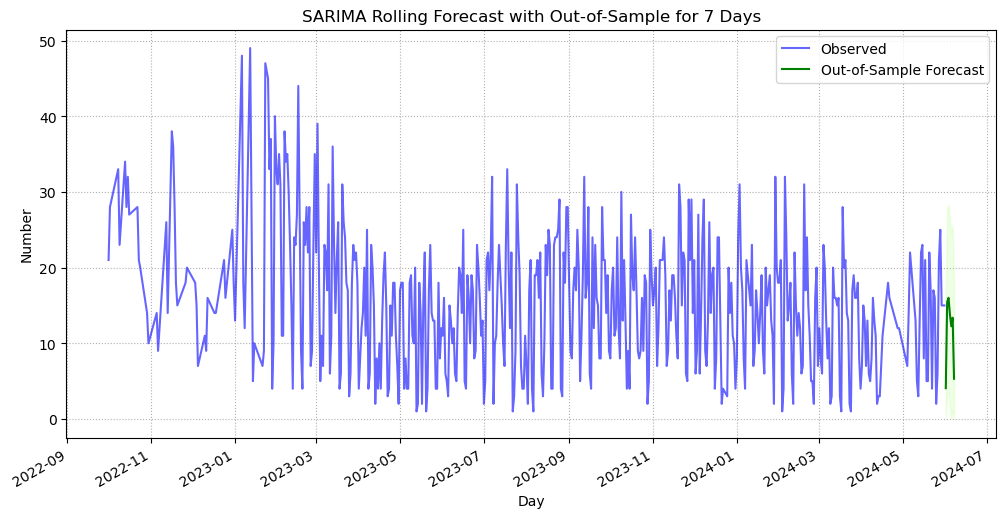

Out-of-Sample Forecast Accuracy: {'mae': nan, 'mse': nan, 'rmse': nan, 'mape': nan}


In [57]:
plt.figure(figsize=(12,6))
plt.plot(Y, label='Observed', color='blue', alpha=0.6) 
#rolling_predictions_series.plot(label='In-Sample Forecast', color='red')
rolling_predictions_out_of_sample.plot(label='Out-of-Sample Forecast', color='green')
#plt.fill_between(lower_ci_series.index, lower_ci_series, upper_ci_series, color='#ff0066', alpha=0.1)
plt.fill_between(lower_ci_out_of_sample.index, lower_ci_out_of_sample, upper_ci_out_of_sample, color='#66ff00', alpha=0.1)

plt.title("SARIMA Rolling Forecast with Out-of-Sample for 7 Days")
plt.xlabel("Day")
plt.ylabel("Number")
plt.legend()
plt.savefig('SARIMA Rolling Forecast with Out-of-Sample for 7 Days.png')
plt.show()

def get_forecast_accuracy(y_true, y_pred):
    mae = np.mean(np.abs(y_true - y_pred))    # Mean Absolute Error
    mse = np.mean((y_true - y_pred)**2)       # Mean Squared Error
    rmse = np.sqrt(mse)                       # Root Mean Squared Error
    mape = np.mean(np.abs(y_true - y_pred) / np.abs(y_true))  # Mean Absolute Percentage Error
    return {'mae': mae, 'mse': mse, 'rmse': rmse, 'mape': mape}

if len(Y) >= h:
    accuracy = get_forecast_accuracy(Y[-h:], rolling_predictions_out_of_sample)
    print("Out-of-Sample Forecast Accuracy:", accuracy)
else:
    print("Y does not have enough values for accuracy calculation.")

In [52]:
results_df = pd.DataFrame({
    'Predictions': rolling_predictions_out_of_sample,
    'Lower CI': lower_ci_out_of_sample,
    'Upper CI': upper_ci_out_of_sample
})

# แสดงผลลัพธ์
print("Out-of-Sample Forecast Results:")
print(results_df)

Out-of-Sample Forecast Results:
            Predictions  Lower CI   Upper CI
2024-06-01     4.073556  0.000000  16.393526
2024-06-02    15.459638  3.149809  27.769467
2024-06-03    16.007418  3.707759  28.307077
2024-06-04    13.828879  1.539404  26.118354
2024-06-05    12.250158  0.000000  24.529378
2024-06-06    13.379995  1.111001  25.648989
2024-06-07     5.315323  0.000000  17.574239


In [53]:
results_df.to_csv('out_of_sample_forecast_results.csv', index=True)

In [ ]:
rolling_predictions_out_of_sample

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(Y, label='Observed', color='blue', alpha=0.6) 
#rolling_predictions_series.plot(label='In-Sample Forecast', color='red')
rolling_predictions_out_of_sample.plot(label='Out-of-Sample Forecast', color='green')
#plt.fill_between(lower_ci_series.index, lower_ci_series, upper_ci_series, color='#ff0066', alpha=0.1)
plt.fill_between(lower_ci_out_of_sample.index, lower_ci_out_of_sample, upper_ci_out_of_sample, color='#66ff00', alpha=0.1)

plt.title("SARIMA Rolling Forecast with Out-of-Sample for 4 Week)
plt.xlabel("Day")
plt.ylabel("Number")
plt.legend()
plt.savefig('SARIMA Rolling Forecast with Out-of-Sample for 4 week.png')
plt.show()

def get_forecast_accuracy(y_true, y_pred):
    mae = np.mean(np.abs(y_true - y_pred))    # Mean Absolute Error
    mse = np.mean((y_true - y_pred)**2)       # Mean Squared Error
    rmse = np.sqrt(mse)                       # Root Mean Squared Error
    mape = np.mean(np.abs(y_true - y_pred) / np.abs(y_true))  # Mean Absolute Percentage Error
    return {'mae': mae, 'mse': mse, 'rmse': rmse, 'mape': mape}

if len(Y) >= h:
    accuracy = get_forecast_accuracy(Y[-h:], rolling_predictions_out_of_sample)
    print("Out-of-Sample Forecast Accuracy:", accuracy)
else:
    print("Y does not have enough values for accuracy calculation.")

In [ ]:
results_df = pd.DataFrame({
    'Predictions': rolling_predictions_out_of_sample,
    'Lower CI': lower_ci_out_of_sample,
    'Upper CI': upper_ci_out_of_sample
})

# แสดงผลลัพธ์
print("Out-of-Sample Forecast Results:")
print(results_df)

In [91]:
# Define the parameters
best_pdq, best_PDQS = (0,1,1),(0,1,1,52)
history_Y = [y for y in Y]
predictions = list()
upper_ci = list()
lower_ci = list()

h = 4  # จำนวนขั้นตอนที่ต้องการพยากรณ์ 4 สัปดาห์

# Rolling Forecast in-sample
for t in range(len(total_case_df) - h + 1):
    model_fit = SARIMAX(history_Y, order=best_pdq, seasonal_order=best_PDQS, trend='n').fit(disp=False)
    output = model_fit.get_forecast(steps=1)
    
    conf_int = output.conf_int()
    output_df = pd.DataFrame({
        'predicted_mean': output.predicted_mean,
        'lower_ci': conf_int.iloc[:, 0],
        'upper_ci': conf_int.iloc[:, 1]
    })
    
    adjusted_lower_ci = max(0, output_df['lower_ci'].iloc[-1])
    predictions.append(output_df['predicted_mean'].iloc[-1])
    lower_ci.append(adjusted_lower_ci)
    upper_ci.append(output_df['upper_ci'].iloc[-1])
    
    # ใช้ค่าพยากรณ์เป็นค่าถัดไปในชุดข้อมูล
    history_Y.append(total_case_df.iloc[t])
    history_Y = history_Y[1:]

# แปลง predictions, lower_ci, upper_ci ให้เป็น pandas Series
rolling_predictions_series = pd.Series(predictions, index=Y.index[h-1:len(predictions)+h-1])
lower_ci_series = pd.Series(lower_ci, index=Y.index[h-1:len(lower_ci)+h-1])
upper_ci_series = pd.Series(upper_ci, index=Y.index[h-1:len(upper_ci)+h-1])

# Rolling Forecast out-of-sample for the next 4 weeks
for i in range(h):
    model_fit = SARIMAX(history_Y, order=best_pdq, seasonal_order=best_PDQS, trend='n').fit(disp=False)
    output = model_fit.get_forecast(steps=1)
    
    conf_int = output.conf_int()
    output_df = pd.DataFrame({
        'predicted_mean': output.predicted_mean,
        'lower_ci': conf_int.iloc[:, 0],
        'upper_ci': conf_int.iloc[:, 1]
    })
    
    adjusted_lower_ci = max(0, output_df['lower_ci'].iloc[-1])
    predictions.append(output_df['predicted_mean'].iloc[-1])
    lower_ci.append(adjusted_lower_ci)
    upper_ci.append(output_df['upper_ci'].iloc[-1])
    
    # ใช้ค่าพยากรณ์เป็นค่าถัดไปในชุดข้อมูล
    history_Y.append(output_df['predicted_mean'].iloc[-1])  # ใช้ค่าพยากรณ์ใหม่

# สร้าง Series สำหรับการพยากรณ์ out-of-sample
out_of_sample_index = pd.date_range(start=Y.index[-1] + pd.Timedelta(weeks=1), periods=h, freq='W')
rolling_predictions_out_of_sample = pd.Series(predictions[-h:], index=out_of_sample_index)
lower_ci_out_of_sample = pd.Series(lower_ci[-h:], index=out_of_sample_index)
upper_ci_out_of_sample = pd.Series(upper_ci[-h:], index=out_of_sample_index)

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [ ]:
total_case_df

In [53]:
#results_df.to_csv('out_of_sample_forecast_results.csv', index=True)